# NYC Taxi Demand-Anomaly Detection
- EECS 731 Project 6
- Author: Lazarus
- ID : 3028051
 
## Problem Statement
###  D(St)reams of Anomalies
####   The real world does not slow down for bad data
1.  Set up a data science project structure in a new git repository in your GitHub account
2.  Download the benchmark data set from:
- https://www.kaggle.com/boltzmannbrain/nab 
- https://github.com/numenta/NAB/tree/master/data
3.  Load the  one  of the data set into panda data frames
4.  Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5.  Build one or more anomaly detection models to determine the  anomalies  using the other columns as features
6.  Document your process and results
7.  Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub



## Data Description
This dataset (nyc_taxi) contains the number of NYC taxi passengers, where the five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm. The raw data is from the NYC Taxi and Limousine Commission. The data file included here consists of aggregating the total number of taxi passengers into 30 minute buckets.

## What we want to do?
- Main goal: to detect anomalies from New york city taxi data
- First we shall go through dataset and understand what features can we use to improve results of our anomaly detector.

## Step 1: Lets prepare working environment
- Import all libraries required in the initial stage for data exploration and feature engineering
- Loading data from csv to a pandas dataframe


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from  datetime import datetime as dt

In [36]:
data= pd.read_csv("https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv")
data["timestamp"]=pd.to_datetime(data.timestamp)
data.tail(5)

,timestamp,value
10315,2015-01-31 21:30:00,24670
10316,2015-01-31 22:00:00,25721
10317,2015-01-31 22:30:00,27309
10318,2015-01-31 23:00:00,26591
10319,2015-01-31 23:30:00,26288


## Step2: Let's plot data to observe patterns in data

(array([735415., 735446., 735477., 735507., 735538., 735568., 735599.,
        735630.]),
 <a list of 8 Text xticklabel objects>)

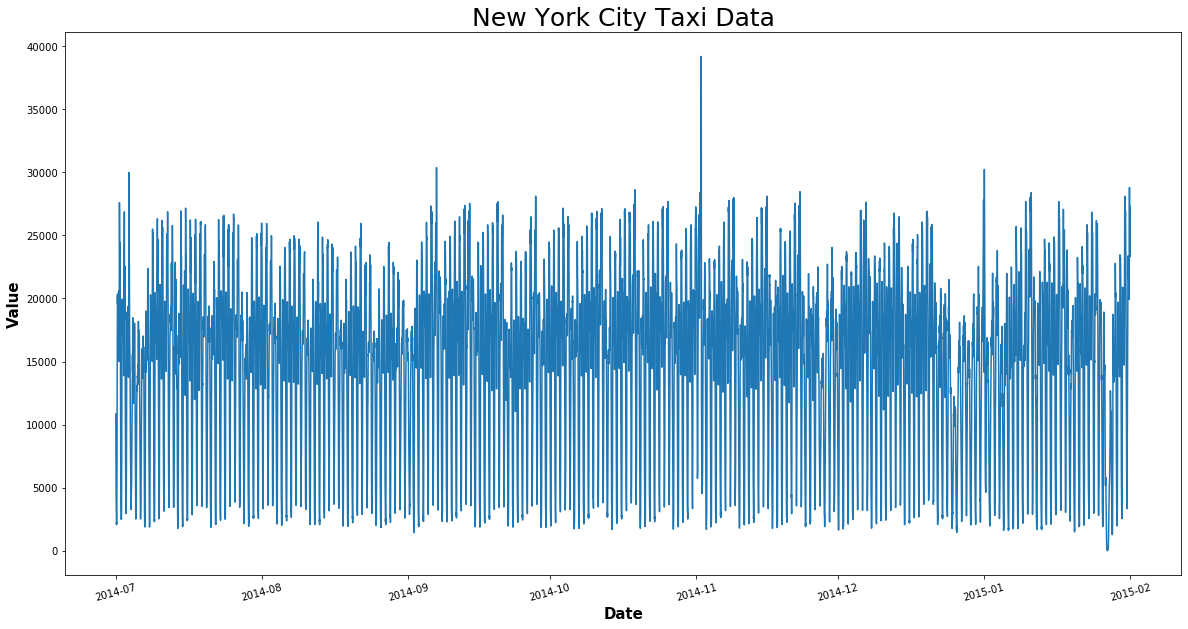

In [37]:
fig, ax = plt.subplots (figsize=(20, 10))
ax.plot (data['timestamp'], list(data['value']))
plt.title("New York City Taxi Data", size=25)
plt.ylabel ('Value', fontweight = 'bold',size=15)
plt.xlabel ('Date', fontweight = 'bold', size=15)
plt.xticks(rotation=15)

- We can clearly see the pattern in data

## Step 3: Feature Engineering
- Now as we have two features timestamp and values. Let's create another feature called changeValues which stores the difference between two continuous samples' values.
- We will plot again to observe the new feature

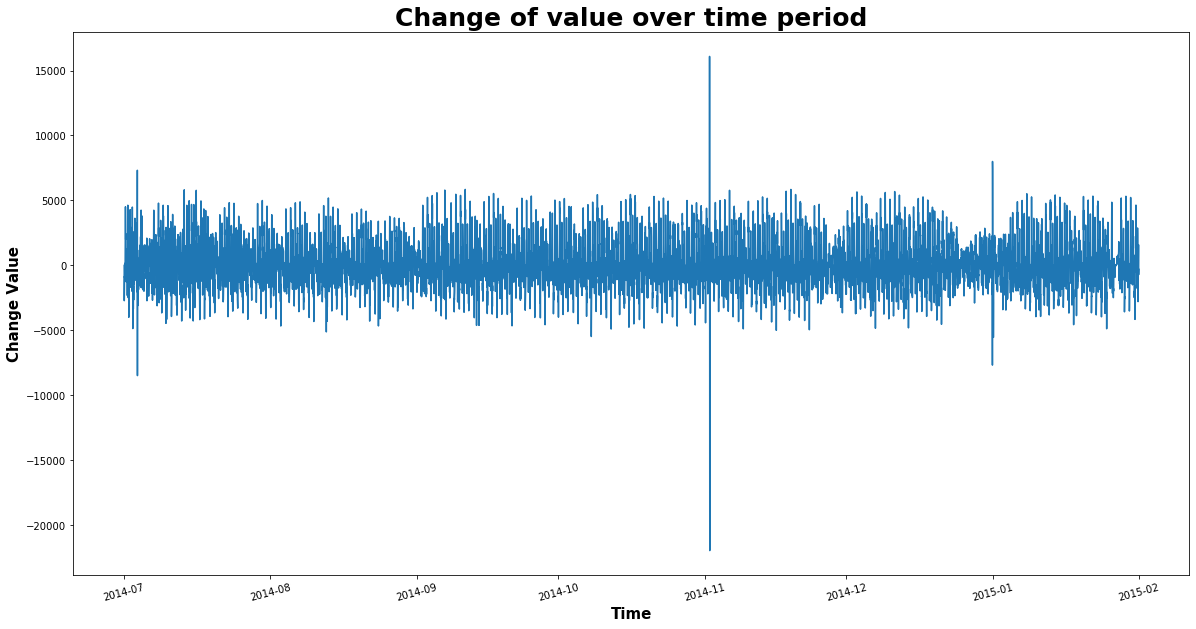

In [38]:
data['changeValue'] = data['value'] - data['value'].shift(1, fill_value=10844)

fig, ax = plt.subplots (figsize=(20,10))
ax.plot (data['timestamp'], list(data['changeValue']))
plt.xticks (rotation=15)
plt.ylabel ('Change Value', fontweight = 'bold', size=15)
plt.xlabel ('Time', fontweight = 'bold', size=15)
plt.title ('Change of value over time period', fontweight = 'bold', size=25)
plt.show ()

- This `changeValue` can be one of the best features to train our models on
- Let's try more
- We will create another feature called moving_average and see if that can help us anymore

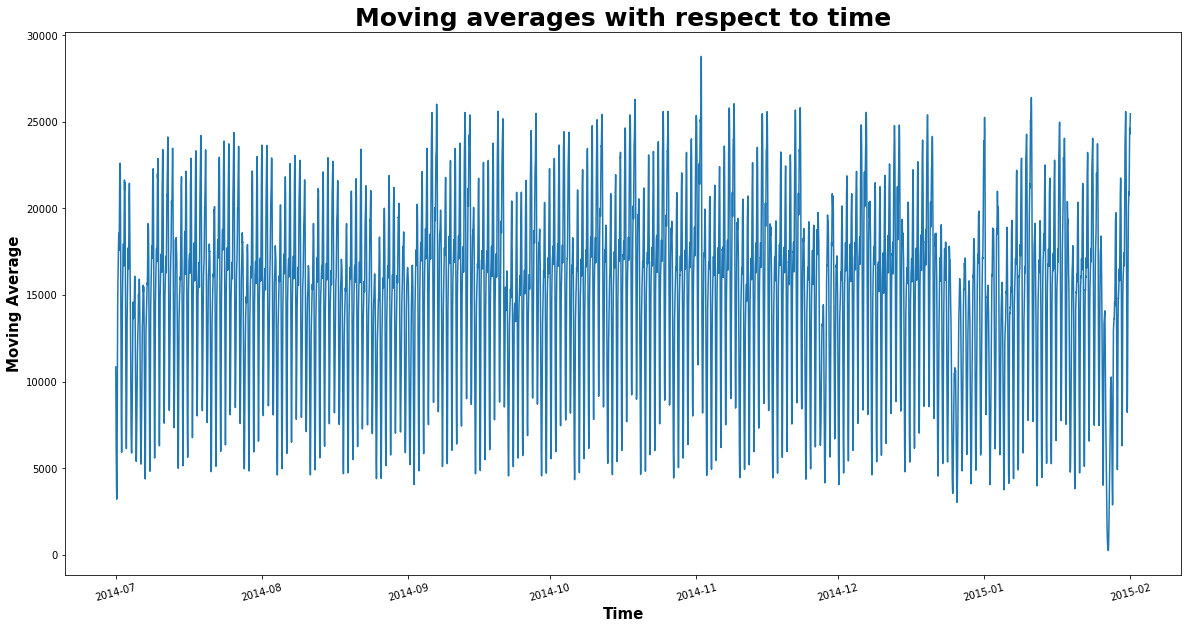

In [51]:
data['moving_average'] = data['value'].ewm(com = 5).mean()

fig, ax = plt.subplots (figsize=(20, 10))
ax.plot (data['timestamp'], list(data['moving_average']))
plt.xticks (rotation=15)
plt.ylabel ('Moving Average', fontweight = 'bold', size=15)
plt.xlabel ('Time', fontweight = 'bold',size=15)
plt.title ('Moving averages with respect to time', size=25, fontweight = 'bold')
plt.show ()

## Step 4: Anomaly detection models:
### One Class SVM
- Let's test our first model based on oneClassSVM

In [40]:
from sklearn.svm import OneClassSVM
OneClassSVMModel = OneClassSVM()
OneClassSVMModel.fit (data[['value']])
data['anomaly'] = pd.Series(OneClassSVMModel.predict(data[['changeValue']]))

#### Let's Visualize results of OneClassSVM based anomaly detector

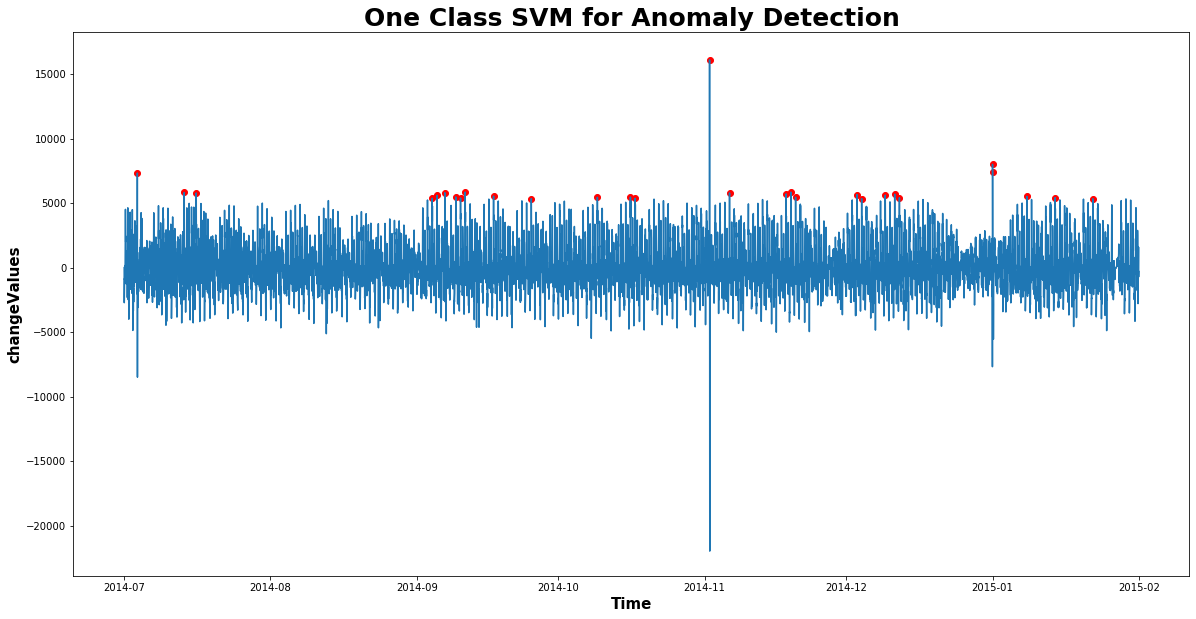

In [67]:
fig, ax = plt.subplots (figsize=(20, 10))
a = data.loc[data['anomaly'] == 1, ['timestamp', 'changeValue']]
ax.plot (data['timestamp'], list(data['changeValue']))
ax.scatter (a['timestamp'], list (a['changeValue']), color = 'red', lw = 1)
plt.title ('One Class SVM for Anomaly Detection', fontweight = 'bold',size=25)
plt.ylabel ('changeValues', fontweight = 'bold', size=15)
plt.xlabel ('Time', fontweight = 'bold', size=15)
plt.show ()

- We see that there are lot more than 5 anomalies detected by this model.
- We can still do better
- Let's check total how many anomalies did this model detect

In [56]:
a.count()

timestamp      29
changeValue    29
dtype: int64

- We have obtained 29 anomalies

## Isolation Forest based Anomaly detector

In [57]:
from sklearn.ensemble import IsolationForest
X = data[["changeValue"]]
clf = IsolationForest(contamination=0.0005,random_state=0).fit(X)
data["anomaly2"]=clf.predict(data[["changeValue"]])

#### Let's visualize results of Isolation Forest based anomaly detector

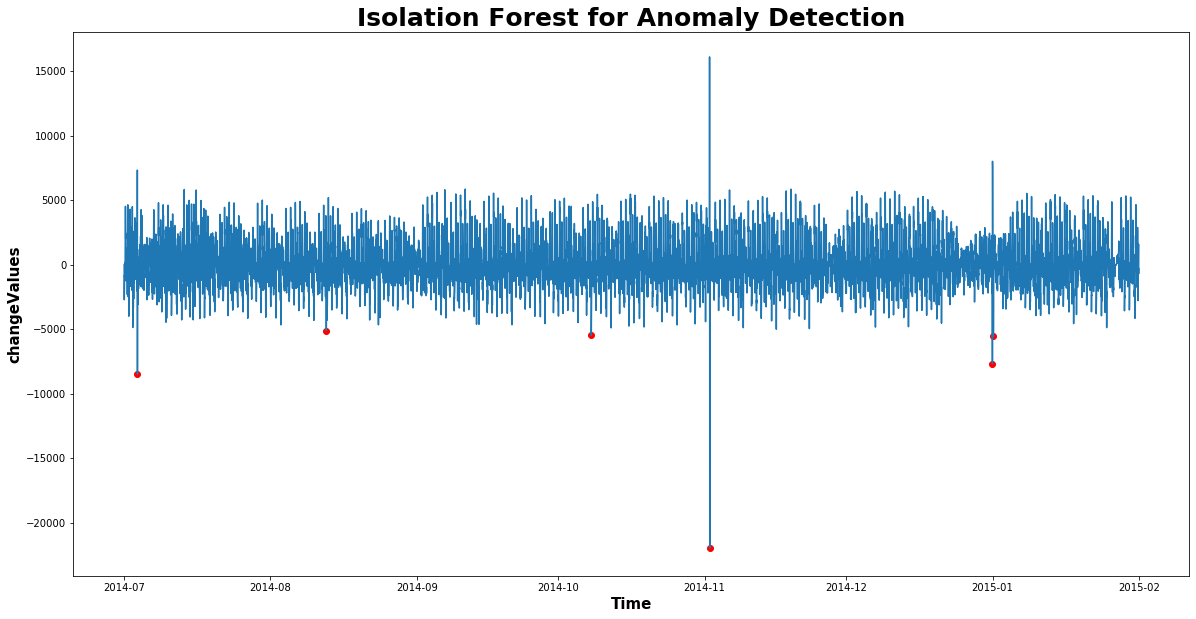

In [61]:
fig, ax = plt.subplots (figsize=(20, 10))
a = data.loc[data['anomaly2'] == -1, ['timestamp', 'changeValue']]
ax.plot (data['timestamp'], list(data['changeValue']))
ax.scatter (a['timestamp'], list (a['changeValue']), color = 'red', lw = 1)
plt.title ('Isolation Forest for Anomaly Detection', fontweight = 'bold', size=25)
plt.ylabel ('changeValues', fontweight = 'bold', size=15)
plt.xlabel ('Time', fontweight = 'bold',size=15)
plt.show ()

In [62]:
a.count()

timestamp      6
changeValue    6
dtype: int64

- We have obtained 6 anomalies and from graph we can see that NYC marathon, Thanksgiving, Christmas, New Years day are noted by this model.

## Local Outlier Factor based Anomaly detector

In [63]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(contamination=0.0005)
data["anomaly3"]=clf.fit_predict(X)

#### Let's visualize to understand better how this model performed

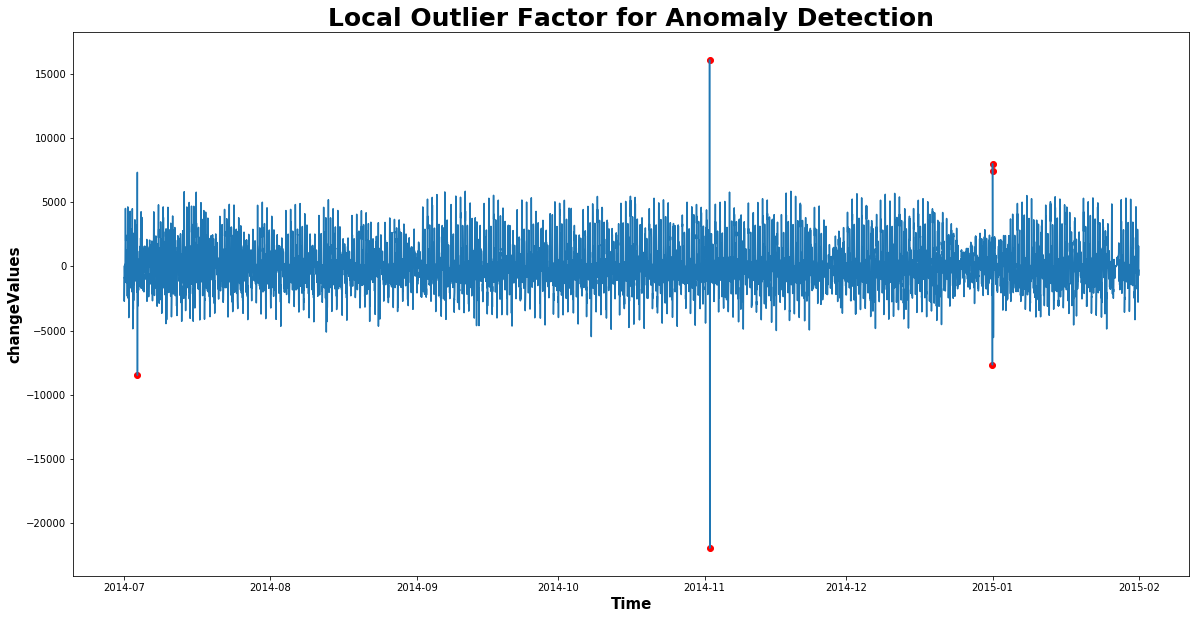

In [66]:
fig, ax = plt.subplots (figsize=(20, 10))
a = data.loc[data['anomaly3'] == -1, ['timestamp', 'changeValue']]
ax.plot (data['timestamp'], list(data['changeValue']))
ax.scatter (a['timestamp'], list (a['changeValue']), color = 'red', lw = 1)
plt.title ('Local Outlier Factor for Anomaly Detection', fontweight = 'bold', size=25)
plt.ylabel ('changeValues', fontweight = 'bold', size=15)
plt.xlabel ('Time', fontweight = 'bold', size=15)
plt.show ()

- We can see that NYC marathon, Thanksgiving, Christmas, New Years day are again pointed out by this model too.

### Conclusion and Further improvements

- Our models performed quite well on this data but am not sure if these models perform the best with other similar data too, it would only be fair to test on other data and evaluate its performance.
- From this project, we see that Local Outlier Factor and Isolation Forest performed better than OneClassSVM model


- In future, we can tweak certain parameters such as contamination which we used in this project and others to get the most of these models.